#使用 pynbodyext 简单教程
https://github.com/wx-ys/pynbody-extras 

从 pynbodyext 中 import 一些工具函数

In [1]:
from pynbodyext.properties import ParameterContain,ParamSum,KappaRot
from pynbodyext.transforms import PosToCenter,VelToCenter,AlignAngMomVec, WrapBox
from pynbodyext.filters import Sphere, FamilyFilter

# 可以 通过 PropertyBase TransformBase FilterBase 自定义 额外的 功能

即使 暂时没有载入模拟数据，但是依然 可以提前 定义和组合各种属性计算、坐标变换和粒子筛选，这些计算流程

In [ ]:
re = ParameterContain("r",0.5,"mass").with_filter(FamilyFilter("stars"))
# 计算 恒星的半质量半径


poscen = PosToCenter("ssc").with_transformation(WrapBox())
# 先通过 WrapBox处理周期边条，然后 移动星系到坐标中心


centeron = VelToCenter().with_filter(Sphere(0.5*re)&FamilyFilter("stars")
                ).with_transformation(poscen)
# 先做poscen的坐标变换，然后计算 0.5*re范围内恒星的速度中心


faceon = AlignAngMomVec().with_filter(Sphere(2*re)&FamilyFilter("stars")
            ).with_transformation(centeron)
# 先做centeron的坐标变换，然后通过 2*re范围内恒星的角动量方向 进行 faceon


krot = KappaRot().with_filter(Sphere("30 kpc")&FamilyFilter("stars")).with_transformation(faceon)
# 先做faceon的坐标变换，然后计算 30 kpc范围内恒星的旋转动能比


test = (krot+krot)/krot
# 一个测试 例子 应该输出 2

然后我们 通过 AnastrisTNG 引入 TNG 的一些数据

In [3]:
from AnastrisTNG import TNGsimulation

path = '/home/yxi/Simulation/sims/TNG50-1/output'
snap =99
snapshot = TNGsimulation.Snapshot(path,snap)
snapshot.load_particle_para['star_fields']=['GFM_StellarFormationTime','BirthPos','GFM_StellarPhotometrics','GFM_InitialMass']
snapshot.load_particle_para['gas_fields']=['ElectronAbundance','GFM_CoolingRate','GFM_Metallicity','GFM_Metals','InternalEnergy','Machnumber','StarFormationRate']    

ID = 8
sim = snapshot.load_particle(ID)
sim

<Subhalo "TNG50-1_snapshot99_Subhalo_8" SubhaloID=8>

In [ ]:
# 未做任何处理的原始数据
sim['pos']

SimArray([[ 8070.65770995, 24389.39676204, 20882.2948814 ],
          [ 8070.56529487, 24389.37200714, 20882.30831071],
          [ 8070.63292371, 24389.38339157, 20882.44242408],
          ...,
          [ 8081.25117851, 24367.59635199, 20863.19984034],
          [ 8048.1798153 , 24423.74059149, 20870.07192481],
          [ 8070.63116996, 24389.38180322, 20882.31152792]],
         shape=(1766918, 3), 'a kpc h**-1')

In [5]:
krot.enable_perf()(sim)

pynext: [INFO     ] 2025-11-22 22:48:25,731 
<Prop KappaRot ()> : <Subhalo "TNG50-1_snapshot99_Subhalo_8" SubhaloID=8>
-------------------------------------------------------------------------------
Step            |         Time |        Mem Used |        Peak Mem |      RSS Δ
-------------------------------------------------------------------------------
transform       |      1.207 s |       30.38 MiB |       93.57 MiB |   9.32 MiB
filter          |     78.63 ms |       12.63 MiB |       18.42 MiB |      0.0 B
calculate       |    309.49 ms |       40.45 MiB |       85.58 MiB |  38.88 MiB
revert          |    536.61 ms |      -58.98 MiB |       40.51 MiB | -55.77 MiB
-------------------------------------------------------------------------------
Total           |      2.136 s |       24.48 MiB |      128.59 MiB |  -7.58 MiB
-------------------------------------------------------------------------------


0.7035615594528464

通过krot的 enable_perf 进行性能统计，

In [ ]:
# 可以看到计算后 sim 的数据没有发生变化
sim['pos']

SimArray([[ 8070.65770995, 24389.39676204, 20882.2948814 ],
          [ 8070.56529487, 24389.37200714, 20882.30831071],
          [ 8070.63292371, 24389.38339157, 20882.44242408],
          ...,
          [ 8081.25117851, 24367.59635199, 20863.19984034],
          [ 8048.1798153 , 24423.74059149, 20870.07192481],
          [ 8070.63116996, 24389.38180322, 20882.31152792]],
         shape=(1766918, 3), 'a kpc h**-1')

In [7]:
# 可以看到 预期的 2
test.enable_perf()(sim)

pynext: [INFO     ] 2025-11-22 22:48:30,096 
OpProperty(op='truediv', operands=2, basic=3, ops=2, depth=3) : <Subhalo "TNG50-1_snapshot99_Subhalo_8" SubhaloID=8>
-------------------------------------------------------------------------------
Step            |         Time |        Mem Used |        Peak Mem |      RSS Δ
-------------------------------------------------------------------------------
transform       |       3.9 μs |        -216.0 B |        41.5 KiB |      0.0 B
filter          |       2.5 μs |          32.0 B |        41.4 KiB |      0.0 B
calculate       |      1.760 s |       11.82 MiB |      120.57 MiB | -13.68 MiB
-------------------------------------------------------------------------------
Total           |      1.762 s |       11.82 MiB |      120.57 MiB | -13.68 MiB
-------------------------------------------------------------------------------


2.0

##### 此外 可以通过 & 连接 多个计算量，统一做 坐标变换 和 粒子筛选， 然后统一计算 返回值

In [8]:
properties = (ParameterContain("rxy",0.5,"mass") & KappaRot() & ParamSum("mass")
              ).with_filter(Sphere("30 kpc")&FamilyFilter("stars")
                ).with_transformation(faceon)
              
# 此处可以看到 类型提示（如果你开启pylance的话），(variable) properties: CombinedCalculator[SimArray, float, SimArray]， 
# 即类型提示 表明返回 SimArray, float, SimArray 三个类型，可以反应计算器的组合的返回值类型

In [9]:
properties(sim)

(SimArray(3.02232968, 'a kpc h**-1'),
 0.7035615594528464,
 SimArray(2.45934048, '1.00e+10 Msol h**-1'))

In [10]:
# 接受数据
Re_30, krot_30, m_star_30 = properties(sim)

In [11]:
# 可以做相应的单位转换
Re_30.in_units("kpc")

SimArray(4.46166177, 'kpc')

In [12]:
m_star_30.in_units("Msol")

SimArray(3.63055873e+10, 'Msol')

##### 计算径向轮廓

In [13]:
from pynbodyext.profiles import RadialProfileBuilder
# 可以通过 pynbodyext.profiles.proarray 中 StatisticBase 自定义 额外的 统计量

In [14]:
sim.physical_units()    # 单位物理化，这样之后就可以不用每次手动转换单位
pr = RadialProfileBuilder(ndim=2,weight="mass",bins_type="equaln",bin_min=0.,bin_max=5*re).with_transformation(faceon, revert=False)
# 径向轮廓，ndim=2为 投影2维，bins_type="equaln"为等数分箱，bin_min和bin_max为径向范围，
# 这里 bin_max=5*re 表示为 5倍的有效半径，re会在 pr(sim)的同时 也计算出来
# with_transformation 中给了 faceon的坐标转换，注意这里 revert=False 表示不反转坐标变换，因为后续 pr 还需要用sim的粒子数据进行后续的计算

In [15]:
prdata = pr(sim)

# pr(sim)  就会返回这个sim 相应的 径向轮廓数据

In [16]:
prdata['rbins'] # 可以通过 输入key值 获取相应的数据

ProfileArray([ 0.08638631,  0.21149824,  0.28299622,  0.34635297,
               0.40979185,  0.47712951,  0.55030322,  0.62987988,
               0.71428947,  0.80213867,  0.89390786,  0.99013367,
               1.0899773 ,  1.19247528,  1.29929999,  1.41470906,
               1.53691164,  1.66425728,  1.79612193,  1.92905546,
               2.06371907,  2.20142717,  2.34258571,  2.48595038,
               2.63032594,  2.77563668,  2.92074015,  3.06522839,
               3.20948001,  3.35548074,  3.50253883,  3.65044558,
               3.80029674,  3.95090214,  4.10170583,  4.25346559,
               4.40486126,  4.55560736,  4.70846891,  4.860737  ,
               5.01104783,  5.16303562,  5.31785603,  5.47576903,
               5.63576388,  5.79645222,  5.96007671,  6.12713644,
               6.29526572,  6.46460018,  6.63314793,  6.8007132 ,
               6.96817591,  7.13369652,  7.30132302,  7.4729679 ,
               7.64868297,  7.83042274,  8.01695096,  8.20684753,
          

In [17]:
prdata['density']   # 获取密度数据

ProfileArray([9.23156163e+09, 7.50288391e+09, 6.68332803e+09,
              5.97725383e+09, 4.93580058e+09, 4.25851718e+09,
              3.43452426e+09, 2.93215056e+09, 2.60871912e+09,
              2.32901430e+09, 2.00387859e+09, 1.83388054e+09,
              1.61091775e+09, 1.48150694e+09, 1.33085447e+09,
              1.15221382e+09, 1.06091161e+09, 9.45242150e+08,
              9.02650666e+08, 8.29611835e+08, 7.79059981e+08,
              6.99032186e+08, 6.59388631e+08, 6.23195214e+08,
              5.88433166e+08, 5.59692184e+08, 5.32286214e+08,
              5.10833377e+08, 4.85542033e+08, 4.54453735e+08,
              4.41973802e+08, 4.24631165e+08, 4.04592596e+08,
              3.88856007e+08, 3.75506066e+08, 3.61168773e+08,
              3.55877082e+08, 3.44047295e+08, 3.29701277e+08,
              3.23970455e+08, 3.14729312e+08, 2.98209354e+08,
              2.81646883e+08, 2.75915586e+08, 2.64508231e+08,
              2.60186890e+08, 2.45521073e+08, 2.35563781e+08,
        

In [18]:
prdata.s['density'] # 可以像操作 sim 一样操作子集数据， 这里表示 同样的radial轮廓数据，但仅针对恒星粒子

ProfileArray([6.04273412e+09, 5.43308163e+09, 4.88185944e+09,
              4.14781795e+09, 3.33068900e+09, 2.63647931e+09,
              2.04806942e+09, 1.64796145e+09, 1.35997528e+09,
              1.15805664e+09, 9.73580996e+08, 8.31592484e+08,
              7.27754708e+08, 6.45085135e+08, 5.47811417e+08,
              4.58412741e+08, 4.03418154e+08, 3.50068868e+08,
              3.16172048e+08, 2.91304366e+08, 2.62982956e+08,
              2.45523497e+08, 2.22072742e+08, 2.07903270e+08,
              1.93389642e+08, 1.81838981e+08, 1.75099516e+08,
              1.66841175e+08, 1.60214965e+08, 1.50127774e+08,
              1.43822413e+08, 1.33575452e+08, 1.25895031e+08,
              1.18843591e+08, 1.14339665e+08, 1.08196869e+08,
              1.04957522e+08, 9.89443083e+07, 9.24165083e+07,
              9.27565974e+07, 8.91904710e+07, 8.36855196e+07,
              8.15608681e+07, 7.50487518e+07, 7.23155070e+07,
              6.97111141e+07, 6.50991755e+07, 6.12217701e+07,
        

In [19]:
import matplotlib.pyplot as plt
plt.style.use("pynbodyext.util.default") # 使用pynbodyext的默认绘图风格

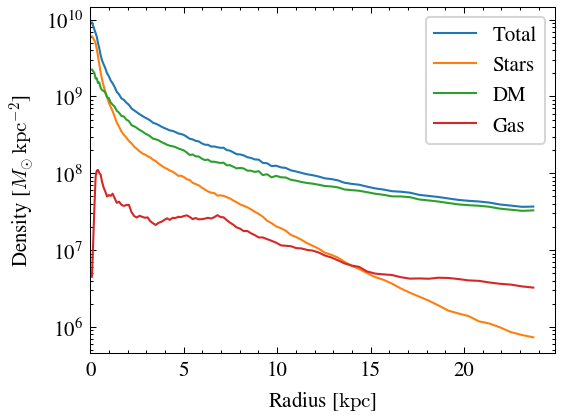

In [20]:
# 画图展示径向轮廓
fig, ax = plt.subplots()

line = ax.plot(prdata['rbins'],prdata['density'],label="Total")
ax.plot(prdata['rbins'],prdata.s['density'],label="Stars")
ax.plot(prdata['rbins'],prdata.dm['density'],label="DM")
ax.plot(prdata['rbins'],prdata.g['density'],label="Gas")

ax.set_xlabel("Radius"+prdata['rbins'].units_latex())
ax.set_ylabel("Density"+prdata['density'].units_latex())
plt.legend()
plt.yscale('log')
plt.xlim(0,)
plt.show()

In [21]:
prdata.g["temp"] # 表示气体的温度数据,(质量加权平均)

ProfileArray([385685.20254155, 255922.15999234, 339171.78490547,
              149968.03783748, 126878.41259913, 105282.53391612,
               93221.06420408,  90580.98095383,  94537.48305522,
               97205.46708313,  82994.66981643,  85339.50788481,
               92909.07165498,  93106.84332524, 104511.61334738,
               74001.36007624,  76303.2423088 ,  73645.22767856,
               61922.25431181,  64078.47514679,  69669.69366528,
               65283.04344694,  72465.76372466,  68516.04768823,
               65321.36725731,  58492.40569055,  64002.32744575,
               57114.20912236,  60583.92328047,  40492.96381575,
               59826.77429822,  55457.76801413,  49356.97105787,
               49777.35883517,  55570.10767649,  53609.50663018,
               53081.11356071,  56822.63764596,  51697.11314599,
               61673.29441237,  49311.24871473,  53651.36240261,
               44929.04063494,  50007.85333174,  48035.57184812,
               55943.8868

In [22]:
prdata.g["temp"]['med'] # 我们可以通过继续 通过key 来获取不同的统计量，比如中位数

ProfileArray([316145.57164227, 104728.79250227, 115537.54827707,
               94705.00780563,  84250.17455351,  77647.94945127,
               72056.49354272,  71849.58684856,  61319.9744982 ,
               60912.32763862,  62760.49078682,  64925.41957882,
               66784.44272129,  62419.81178713,  60500.4668096 ,
               56474.39582461,  50453.46549672,  47452.19627822,
               45114.92093557,  46296.74488502,  43104.055474  ,
               39152.91854656,  34068.05478132,  36513.72130739,
               37365.33618414,  36989.38674975,  36317.34506571,
               34168.77161621,  32341.0955459 ,  29527.83309769,
               30631.41095226,  29981.46485038,  29784.55474007,
               30030.1187563 ,  30225.92008436,  31039.14497498,
               30400.594932  ,  30467.42532983,  30300.11945505,
               31174.91280886,  30540.40277658,  29822.56059887,
               29064.07176076,  28112.3267831 ,  27577.91863352,
               27538.0268

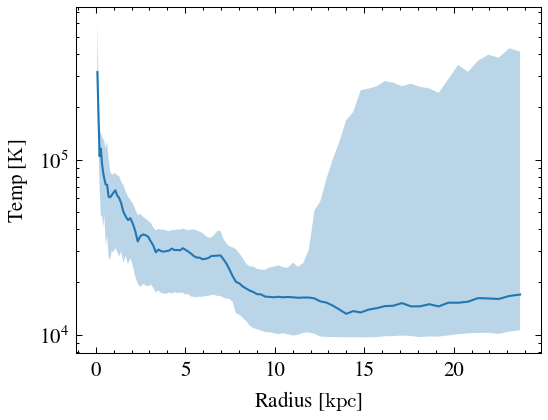

In [23]:
fig, ax = plt.subplots()
ax.plot(prdata.g["rbins"],prdata.g["temp"]['med'],label="Total")
ax.fill_between(prdata.g["rbins"],prdata.g["temp"]["p16"], prdata.g["temp"]["p84"], alpha=0.3) # p**， 表示不同的百分位数区间


plt.xlabel("Radius"+prdata.g["rbins"].units_latex())
plt.ylabel("Temp"+prdata.g["temp"]['med'].units_latex())
plt.yscale('log')
plt.show()

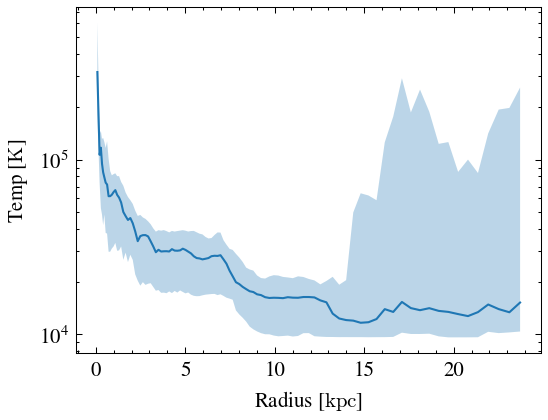

In [24]:
from pynbodyext.filters import Disc
disk_region = Disc(radius=prdata['rbins'][-1],height="3 kpc")  # 也可以给profile传入 filter的数据，会自动筛选相关的粒子 并得到相应的profile

fig, ax = plt.subplots()

ax.plot(prdata.g[disk_region]["rbins"],prdata.g[disk_region]["temp"]['med'],label="Total")
ax.fill_between(prdata.g[disk_region]["rbins"],prdata.g[disk_region]["temp"]["p16"], prdata.g[disk_region]["temp"]["p84"], alpha=0.3)

plt.xlabel("Radius"+prdata.g[disk_region]["rbins"].units_latex())
plt.ylabel("Temp"+prdata.g[disk_region]["temp"]['med'].units_latex())
plt.yscale('log')
plt.show()

In [25]:
prdata      # 可以看到 它的repr 给出的信息，包括 nbins， 拥有的粒子类型，nsubs 表明缓存的子profile的数量，ncache 表明缓存的获取的profile array的缓存数量

<RadialProfile type=root nbins=100 families=['dm', 'star', 'gas', 'bh'] nsubs=4 ncache=22>

In [26]:
from pynbodyext.profiles.time_profile import StarAgeProfile  # 也可以使用 时间相关的 profile， 比如恒星 profile
starpr = StarAgeProfile(sim)

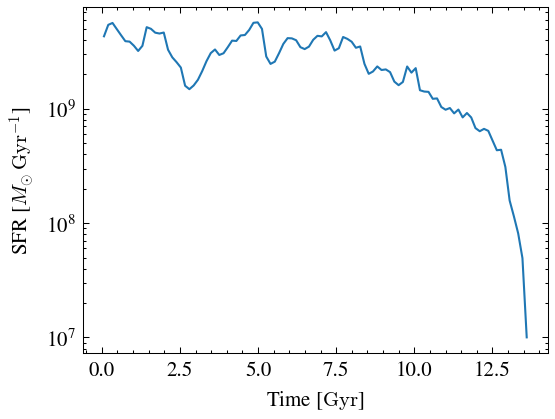

In [27]:
fig, ax = plt.subplots()

ax.plot(starpr['rbins'],starpr["sfr"])

plt.xlabel("Time"+starpr["rbins"].units_latex())
plt.ylabel("SFR"+starpr["sfr"].units_latex())
plt.yscale('log')
plt.show()

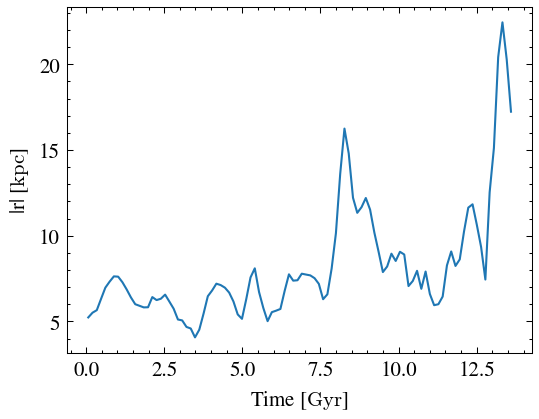

In [28]:
fig, ax = plt.subplots()

ax.plot(starpr['rbins'],starpr["r"]["abs"])     # 查看 不同年龄 恒星的半径分布

plt.xlabel("Time"+starpr["rbins"].units_latex())
plt.ylabel("|r|"+starpr["r"]["abs"].units_latex())
#plt.yscale('log')
plt.show()

In [29]:
starpr

<StarAgeProfile type=root nbins=100 families=['star'] nsubs=0 ncache=7>